In [88]:
import pandas as pd
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import pickle
%matplotlib inline



In [50]:
crashes = pd.read_csv('data/gp_grid_parkslope.csv')

n = len(crashes)
crashes.drop(crashes.columns[0], inplace = True, axis = 1)
crashes.sort_values(['DATE_IND', 'GRID_SQUARE'], inplace = True)
crashes['x_point'] = crashes['x_point'] / 100000  #+ np.random.normal(0,.001, size= n)
crashes['y_point'] = crashes['y_point'] / 100000  #+ np.random.normal(0,.001, size = n)

crashes['x_norm'] = (crashes['x_point'] - crashes['x_point'].mean()) / crashes['x_point'].std()
crashes['y_norm'] = (crashes['y_point'] - crashes['y_point'].mean()) / crashes['y_point'].std()


crashes['GRID_SQUARE'] = crashes['GRID_SQUARE'].astype(np.float32)
crashes['DATE_IND'] = crashes['DATE_IND'].astype(np.float32)

crashes.head()

,DATETIME,GRID_SQUARE,COUNT,x_point,y_point,DATE_IND,x_norm,y_norm
0,2013-05-31,1.0,0.0,9.855685,1.88006,1.0,-1.463592,1.527256
59,2013-05-31,2.0,0.0,9.855685,1.86756,1.0,-1.463592,1.090897
118,2013-05-31,3.0,0.0,9.855685,1.85506,1.0,-1.463592,0.654538
177,2013-05-31,4.0,1.0,9.855685,1.84256,1.0,-1.463592,0.218179
236,2013-05-31,5.0,1.0,9.855685,1.83006,1.0,-1.463592,-0.218179


In [73]:
## source https://www.health.ny.gov/statistics/prevention/injury_prevention/traffic/county_of_residence.htm

per_100k = 696.6 / 12 # for months
per_cap  = per_100k / 100000
e_s = (39.270244500000004 / crashes.GRID_SQUARE.max()) # equally distribute pop among grid cells

#e_s = pop[pop['NTA Name'] == 'Park Slope-Gowanus'].Population.values[0] * per_cap

crashes['e_s'] = e_s

crashes.set_index('DATETIME', inplace = True)
#historical.groupby('BOROUGH')['NUMBER OF PEDESTRIANS INJURED'].sum()


In [119]:
dat = crashes.loc['2015-03-31':'2017-03-31']


X = np.vstack([dat.DATE_IND.values.ravel(), dat.x_point.ravel(), dat.y_point.ravel()]).T
y = dat.COUNT.values.reshape((len(dat),1))

In [120]:
use_priors = True

with gpflow.defer_build():

    like = gpflow.likelihoods.Poisson(binsize = e_s)
    kern_s_effect = gpflow.kernels.RBF(2, active_dims=[1,2], name='space_effect')
    kern_t_effect = gpflow.kernels.RBF(1, active_dims=[0], name='time_effect')

    ## Will have to write custom kernel to match Flaxman 2014
    kern_p_effect = gpflow.kernels.Periodic(1, active_dims=[0], name = 'periodic_effect')
    kern_st_effect = gpflow.kernels.Product([kern_s_effect ,kern_t_effect])

    full_kern =  kern_t_effect + kern_s_effect + kern_p_effect + kern_st_effect
    
    mean = gpflow.mean_functions.Identity(input_dim = 3)
    
    m = gpflow.models.VGP(X, y, full_kern,  likelihood = like, mean_function = None)
    
    m.kern.periodic.period = 12
    m.kern.periodic.period.trainable = True
    
    normal_prior = gpflow.priors.Gaussian(mu = 0 , var = 1)
    if use_priors:
        m.kern.rbf_1.variance.prior    = normal_prior
        m.kern.periodic.variance.prior = normal_prior
        m.kern.rbf_2.variance.prior    = normal_prior
        
        m.kern.rbf_1.lengthscales.prior = normal_prior
        m.kern.rbf_2.lengthscales.prior = normal_prior
        m.kern.periodic.lengthscales.prior = normal_prior


m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
VGP/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 1200, 1200)",True,"[[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
VGP/kern/periodic/lengthscales,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.0
VGP/kern/periodic/period,Parameter,None,+ve,True,(),True,12.0
VGP/kern/periodic/variance,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.0
VGP/kern/rbf_2/variance,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.0
VGP/kern/rbf_2/lengthscales,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.0
VGP/kern/rbf_1/variance,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.0
VGP/kern/rbf_1/lengthscales,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.0
VGP/kern/rbf_1/variance,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.0
VGP/kern/rbf_1/lengthscales,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.0


In [121]:
m.compile()
opt = gpflow.train.ScipyOptimizer()

In [122]:
m.compute_log_likelihood()

-10598.859522976061

In [56]:
#opt.minimize(m, maxiter = 1000)

In [123]:
#opt.minimize(m, maxiter= 500)

custom_config = gpflow.settings.get_settings()
custom_config.numerics.jitter_level = 1e-6

with gpflow.settings.temp_settings(custom_config):
     opt.minimize(m, maxiter=1000)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1715.311562
  Number of iterations: 860
  Number of functions evaluations: 952


In [124]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
VGP/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 1200, 1200)",True,"[[[0.582537778524, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
VGP/kern/periodic/lengthscales,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,0.3185047584074134
VGP/kern/periodic/period,Parameter,None,+ve,True,(),True,12.904425984804728
VGP/kern/periodic/variance,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,0.38781163067267305
VGP/kern/rbf_2/variance,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.6883613994132483
VGP/kern/rbf_2/lengthscales,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,0.01189981728962394
VGP/kern/rbf_1/variance,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,0.05078163328760975
VGP/kern/rbf_1/lengthscales,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,0.8762547597786312
VGP/kern/rbf_1/variance,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,0.05078163328760975
VGP/kern/rbf_1/lengthscales,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,0.8762547597786312


In [125]:
dat = crashes

X = np.vstack([dat.DATE_IND.values.ravel(), dat.x_point, dat.y_point]).T
y = dat.COUNT.values.reshape((len(dat),1))

pred_mean, pred_variance = m.predict_y(X)


In [126]:
dat['pred'] = pred_mean


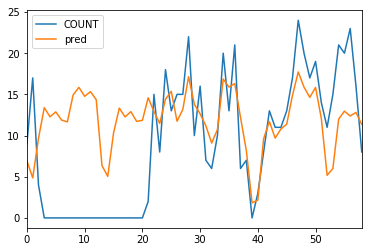

In [127]:
dat[dat.GRID_SQUARE == 33 ].reset_index()[['COUNT', 'pred']].plot()

In [128]:
predicted = crashes[crashes.DATE_IND >= 48].copy()

(np.square(predicted.pred - predicted.COUNT).sum()) * (1 / len(predicted))

3.980325622122229

In [129]:
predicted['error'] = (predicted.pred - predicted.COUNT)
predicted['sq_error'] = np.square(predicted['error'])

forecast = predicted.groupby('DATETIME')
forecasting_error = forecast['sq_error'].sum() * (1 / forecast['GRID_SQUARE'].count())

forecasting_error



DATETIME
2017-04-30    6.496037
2017-05-31    4.472845
2017-06-30    2.444178
2017-07-31    3.901682
2017-08-31    2.015819
2017-09-30    4.151013
2017-10-31    4.302192
2017-11-30    3.989077
2017-12-31    4.387397
2018-01-31    5.599164
2018-02-28    2.657746
2018-03-31    3.346759
dtype: float64

In [130]:
aggregate_forecast = predicted.groupby('DATETIME')[['pred','COUNT']].sum()
aggregate_forecast['sq_error'] = np.square(aggregate_forecast.pred - aggregate_forecast.COUNT)

np.sqrt(aggregate_forecast.sq_error * (1 / len(aggregate_forecast)))

DATETIME
2017-04-30     9.899319
2017-05-31     0.223475
2017-06-30     1.159671
2017-07-31     8.175451
2017-08-31     6.602959
2017-09-30    14.596717
2017-10-31    15.529544
2017-11-30     0.095845
2017-12-31     1.925806
2018-01-31     7.256586
2018-02-28     4.011713
2018-03-31    16.244542
Name: sq_error, dtype: float64

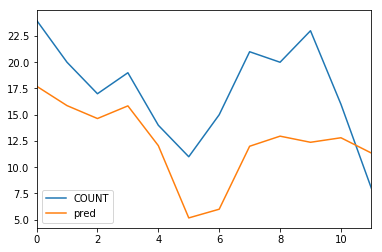

In [131]:
predicted[predicted.GRID_SQUARE == 33 ].reset_index()[['COUNT', 'pred']].plot()

In [132]:
#
params = m.read_trainables()
#pickle.dump( params, open( "best_model_so_far.p", "wb" ) )
